In [1]:
from mae.encoder import *
from mae.decoder import *
from dataset import *
import gin

In [2]:
gin.parse_config_file("config/encoder_config1.gin")
encoder_config = EncoderConfig()

gin.parse_config_file("config/decoder_config1.gin")
decoder_config = DecoderConfig()

In [3]:
decoder_config

DecoderConfig(image_size=128, in_proj_dim=256, hidden_size=256, intermediate_size=768, num_hidden_layers=4, num_attention_heads=2, num_channels=3, patch_size=8, norm_eps=1e-08, attention_dropout=0.0, do_loss_calculation=True, num_image_tokens=256, head_dim=128, patched_image_height=16, patched_image_width=16)

In [4]:
encoder = Encoder(encoder_config)
decoder = Decoder(decoder_config)

In [5]:
# # initialize the parameters of the encoder
# def initialize_encoder_parameters(module):
#     if isinstance(module, nn.Linear):
#         nn.init.xavier_uniform_(module.weight)
#         if module.bias is not None:
#             nn.init.zeros_(module.bias)
#     elif isinstance(module, nn.Embedding):
#         nn.init.normal_(module.weight, mean=0.0, std=0.02)
#     elif isinstance(module, nn.LayerNorm):
#         nn.init.constant_(module.weight, 1.0)
#         nn.init.constant_(module.bias, 0.0)

# encoder.apply(initialize_encoder_parameters)

In [6]:
# img, class_name = next(iter(train_dataloader))
# img.shape, class_name

# sample input 
img = torch.randn(1, 3, 128, 128)

In [7]:
encoder_op, mask, ids_restore = encoder(img)
decoder_op = decoder((encoder_op, mask, ids_restore), img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2331173..2.207382].


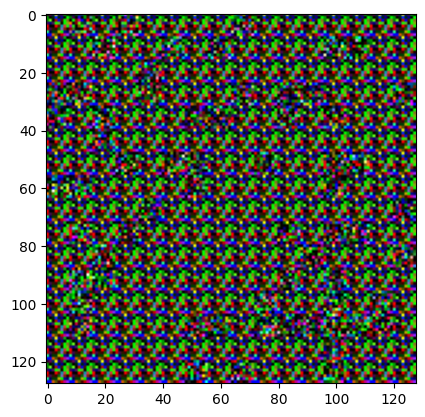

In [8]:
import matplotlib.pyplot as plt
plt.imshow(decoder_op[0].squeeze(0).detach().cpu().permute(1, 2, 0));

In [9]:
from dataset import *

In [10]:
import os
files = os.listdir("dataset")
ds = Birddataset("dataset/", allowed_classes=files, dataset_type="train", do_transform=True)

In [11]:
train_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "train")
test_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "test")

In [12]:
train_dataset.__len__()
test_dataset.__len__()

12

In [13]:
train_dataset.__getitem__(0)[0].shape

torch.Size([3, 128, 128])